In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# kaggle competition https://www.kaggle.com/c/shelter-animal-outcomes/data

In [3]:
# we will take train dataset from Kaggle and split it into train/ test (we cannot use test dataset from Kaggle
# since it has no labels)
all_data = pd.read_csv("shelter-animal-outcomes/train.csv")

In [4]:
all_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
all_data.shape

(26729, 10)

In [6]:
all_data.OutcomeType.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [7]:
all_data.isna().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [8]:
all_data['SexuponOutcome'] =all_data['SexuponOutcome'].fillna("Neutered Male")

In [9]:
del all_data["AnimalID"]
del all_data["OutcomeSubtype"]

In [10]:
# make a column if the name is known or not
all_data['Name'] =all_data['Name'].fillna(0)
all_data.loc[all_data['Name'] != 0, "Name"] = 1

all_data.loc[all_data["AnimalType"]== "Dog", "AnimalType"] = 1
all_data.loc[all_data["AnimalType"]!= 1, "AnimalType"] = 0

In [11]:
# Let's create "Day_of_week" and "Hour" columns:
all_data['Hour'] = all_data.DateTime.map( lambda x: pd.to_datetime(x).hour )
all_data['Day_of_Week'] = all_data.DateTime.map( lambda x: pd.to_datetime(x).dayofweek )

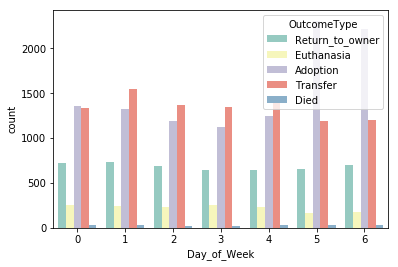

In [12]:
import seaborn as sns
%matplotlib inline

sns.countplot(data=all_data, x='Day_of_Week',hue="OutcomeType", palette = "Set3")

In [13]:
# "5" and "6" means "Suturday" and "Sunday". The animals are more likely adopted at Weekends! 
# Thus, I am replacing 5 and 6 by 1, and other numbers by 0
all_data.loc[all_data["Day_of_Week"]== 5, "Day_of_Week"] = 10
all_data.loc[all_data["Day_of_Week"]== 6, "Day_of_Week"] = 10
all_data.loc[all_data["Day_of_Week"]!= 10, "Day_of_Week"] = 0
all_data.loc[all_data["Day_of_Week"]== 10, "Day_of_Week"] = 1

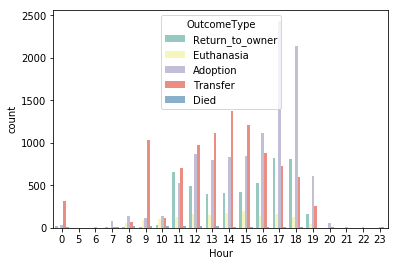

In [14]:
sns.countplot(data=all_data, x='Hour',hue="OutcomeType", palette = "Set3")

It is interesting! The animal are adopted more likely at 16-19 and 7-8; transfered at 0, 9, 12-15. Thus, I am going to create features: 16and19, 17and18, 7and8, 9, 0, 12and13, 14and15, other_time.

In [15]:
def day(x):
    if x == 16 or x == 19:
        x = "16and19"
    elif x == 17 or x == 18:
        x = "17and18"
    elif x == 7 or x == 8:
        x = "7and8"
    elif x == 12 or x == 13:
        x = "12and13"
    elif x == 14 or x == 15:
        x = "14and15"
    elif x == 9:
        x = "9"
    elif x == 0:
        x = "0"
    else:
        x = "other_time"
    return x
       
all_data['Hour'] = all_data.Hour.apply(day)

In [16]:
def age_as_float(x):
    x = str(x)
    x_list = x.split(" ")
    if len(x_list)==2:
        if x_list[1] =='year': return 1.0
        elif x_list[1] =='years': return float(x_list[0])
        elif x_list[1] =='month': return float(x_list[0])/12
        elif x_list[1] =='months': return float(x_list[0])/12
        elif x_list[1] =='week': return float(x_list[0])
        elif x_list[1] =='weeks': return float(x_list[0])/54
        elif x_list[1] =='days': return float(x_list[0])/365
        else: return 0
    else:return 0

all_data['AgeuponOutcome'] = all_data.AgeuponOutcome.apply(age_as_float)
#now we have 0 age for the animals with undefined age. Let's replace 0 by mean age:
all_data.loc[all_data['AgeuponOutcome']== 0, "AgeuponOutcome"] = all_data['AgeuponOutcome'].median()

In [17]:
#I used tutorial from https://www.dataquest.io/learn
def create_dummies(var):
    var_unique = var.unique()
    var_unique.sort()
    dummy = pd.DataFrame()
    for val in var_unique:
    #for val in var_unique[:-1]:
        # which columns are equal to our unique value
        d = var == val
        # make a new column with a dummy variable
        dummy[var.name + "_" + str(val)] = d.astype(int)
    return(dummy)

sex_dummies = create_dummies(all_data["SexuponOutcome"])
data = pd.concat([all_data, sex_dummies], axis=1)
del all_data["SexuponOutcome"]

hour = create_dummies(all_data["Hour"])
all_data = pd.concat([all_data, hour], axis=1)
del all_data["Hour"]

In [18]:
items_counts = data['Breed'].value_counts()
# we are going to work with breeds with count > 150. Also, I am going to add "Boxer" and "Pit Bull" to my list since this dogs can be agressive.

In [19]:
to_my_breads = all_data['Breed'].value_counts() > 150

In [20]:
items_counts[to_my_breads]

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Boxer Mix                     245
Miniature Poodle Mix          233
Border Collie Mix             229
Australian Shepherd Mix       163
Rat Terrier Mix               157
Catahoula Mix                 157
Name: Breed, dtype: int64

In [21]:
my_breeds = ["Domestic Shorthair", "Chihuahua Shorthair", "Labrador Retriever", 
             "Domestic Medium Hair", "German Shepherd", "Domestic Longhair", "Siamese", "Australian Cattle Dog", 
             "Dachshund", "Miniature Poodle", "Border Collie","Australian Shepherd", "Rat Terrier", "Catahoula", 
              "Husky", "Rottweiler", "Bulldog", "Pit Bull", "Boxer"]

In [22]:
import re
def breeds(x):
    x = str(x)
    breed = "other"
    for b in my_breeds:
        if re.search(b, x):
            breed = b
    return breed
all_data['My_Breeds'] = all_data.Breed.apply(breeds)

In [23]:
breed_dummies = create_dummies(all_data["My_Breeds"])
all_data = pd.concat([all_data, breed_dummies], axis=1)
del all_data["My_Breeds"]
del all_data["Breed"]

In [24]:
features = all_data.columns.tolist() 
print(features)

['Name', 'DateTime', 'OutcomeType', 'AnimalType', 'AgeuponOutcome', 'Color', 'Day_of_Week', 'Hour_0', 'Hour_12and13', 'Hour_14and15', 'Hour_16and19', 'Hour_17and18', 'Hour_7and8', 'Hour_9', 'Hour_other_time', 'My_Breeds_Australian Cattle Dog', 'My_Breeds_Australian Shepherd', 'My_Breeds_Border Collie', 'My_Breeds_Boxer', 'My_Breeds_Bulldog', 'My_Breeds_Catahoula', 'My_Breeds_Chihuahua Shorthair', 'My_Breeds_Dachshund', 'My_Breeds_Domestic Longhair', 'My_Breeds_Domestic Medium Hair', 'My_Breeds_Domestic Shorthair', 'My_Breeds_German Shepherd', 'My_Breeds_Husky', 'My_Breeds_Labrador Retriever', 'My_Breeds_Miniature Poodle', 'My_Breeds_Pit Bull', 'My_Breeds_Rat Terrier', 'My_Breeds_Rottweiler', 'My_Breeds_Siamese', 'My_Breeds_other']


In [25]:
features.remove("DateTime")
features.remove("OutcomeType")
features.remove("Color")

In [26]:
# random shift
all_data = all_data.sample(frac=1)

In [27]:
all_data.head()

,Name,DateTime,OutcomeType,AnimalType,AgeuponOutcome,Color,Day_of_Week,Hour_0,Hour_12and13,Hour_14and15,...,My_Breeds_Domestic Shorthair,My_Breeds_German Shepherd,My_Breeds_Husky,My_Breeds_Labrador Retriever,My_Breeds_Miniature Poodle,My_Breeds_Pit Bull,My_Breeds_Rat Terrier,My_Breeds_Rottweiler,My_Breeds_Siamese,My_Breeds_other
5919,0,2014-06-19 17:11:00,Transfer,1,0.166667,Black/Tan,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11553,1,2014-07-13 07:59:00,Adoption,0,0.250000,Tortie,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
22933,1,2015-12-10 16:58:00,Transfer,1,0.500000,Black,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
13770,1,2014-04-26 15:40:00,Adoption,0,7.000000,Black,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
17558,1,2015-08-03 15:02:00,Euthanasia,1,1.000000,Yellow/White,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [28]:
seed = 7

X = all_data[features]
y = all_data.OutcomeType

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [29]:
X_train.shape

(21383, 32)

## Decision Trees

Decision Trees. For the decision tree, you should implement or steal a decision tree algorithm (and by "implement or steal" I mean "steal"). Be sure to use some form of pruning. You are not required to use information gain (for example, there is something called the GINI index that is sometimes used) to split attributes, but you should describe whatever it is that you do use.

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import accuracy_score

In [59]:
# in sklearn we can use the maximum depth of the tree for pruning 
# and The minimum number of samples required to split an internal node

max_depth = [5, 10, 15, 25, 40]
min_samples_split = [2,8,20, 100]

for m in max_depth:
    print("max_depth: ", m)
    for n in min_samples_split:
        clf = DecisionTreeClassifier(random_state=0, max_depth=m, min_samples_split=n) # by defauld the model use GINI
        scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        print(" min_samples_split: ", n, " accuracy: ", np.median(scores))

max_depth:  5
 min_samples_split:  2  accuracy:  0.6012155212716223
 min_samples_split:  8  accuracy:  0.6012155212716223
 min_samples_split:  20  accuracy:  0.6012155212716223
 min_samples_split:  100  accuracy:  0.6012155212716223
max_depth:  10
 min_samples_split:  2  accuracy:  0.6294736842105263
 min_samples_split:  8  accuracy:  0.6301754385964913
 min_samples_split:  20  accuracy:  0.6266666666666667
 min_samples_split:  100  accuracy:  0.6266666666666667
max_depth:  15
 min_samples_split:  2  accuracy:  0.6093567251461989
 min_samples_split:  8  accuracy:  0.6128654970760234
 min_samples_split:  20  accuracy:  0.615906432748538
 min_samples_split:  100  accuracy:  0.6224561403508772
max_depth:  25
 min_samples_split:  2  accuracy:  0.5944366526414212
 min_samples_split:  8  accuracy:  0.6026180458158018
 min_samples_split:  20  accuracy:  0.6091631603553063
 min_samples_split:  100  accuracy:  0.6175783076203833
max_depth:  40
 min_samples_split:  2  accuracy:  0.59461988304093

In [60]:
# predict on the test data using the best parameters
clf = DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_split=8)
clf.fit(X_train, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
pr = clf.predict(X_test)
print("Testing accuracy: ", accuracy_score(y_test, pr))

Training accuracy:  0.6537436281157929
Testing accuracy:  0.6264496820052375


In [61]:
print(list(clf.feature_importances_))

[0.25308907401019487, 0.073187230315976, 0.33279237415188634, 0.04693678484154791, 0.021640798495063833, 0.006410928167108715, 0.006898068476748525, 0.01700236416053026, 0.12826280257899783, 0.007301553332353222, 0.03182716633603703, 0.016404530444867164, 0.002647312440714663, 0.0030690100945930943, 0.0021216084827929524, 0.0008225085824062259, 0.0008897709448819758, 0.0007039590291126499, 0.004105104075576025, 0.004222039397633536, 0.001693903047176416, 0.0027587593556377427, 0.0031766773134669583, 0.0013952713455404936, 0.0009336362651602868, 0.0020342221263102765, 0.001965559965172224, 0.012989022586951289, 0.0009473669516310184, 0.0015529595193614289, 0.0038303418601803576, 0.006387291304388727]


###  Learning curves 

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import learning_curve

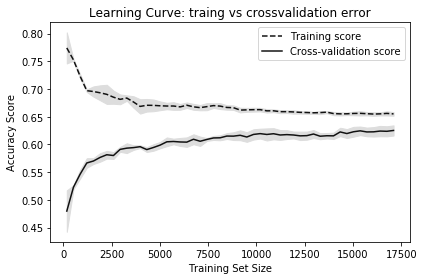

In [66]:
# I used this blog: https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_split=8), 
                                                        X_train, 
                                                        y_train,
                                                        cv=5,
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve: traing vs crossvalidation error")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [67]:
tr_size = np.linspace(0.01, 1.0, 50)
size = []
tr_accuracy = []
test_accuracy = []
n_tr_samples = X_train.shape[0]
for t in tr_size:
    clf = DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_split=8)
    clf.fit(X_train[ :int(n_tr_samples*t)], y_train[ :int(n_tr_samples*t)])
    size.append(int(n_tr_samples*t))
    t = accuracy_score(y_train[ :int(n_tr_samples*t)],clf.predict(X_train[ :int(n_tr_samples*t)]) )
    tr_accuracy.append(t)
    test_accuracy.append(accuracy_score(y_test, clf.predict(X_test)))

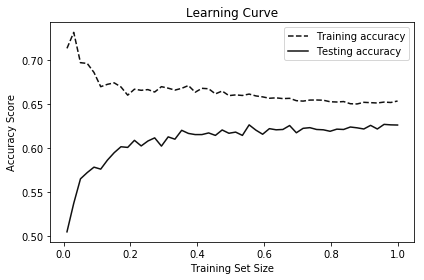

In [68]:
# Draw lines
plt.plot(tr_size, tr_accuracy, '--', color="#111111",  label="Training accuracy")
plt.plot(tr_size, test_accuracy, color="#111111", label="Testing accuracy")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Neural Networks

Neural Networks. For the neural network you should implement or steal your favorite kind of network and training algorithm. You may use networks of nodes with as many layers as you like and any activation function you see fit.

In [54]:
# I used this model: https://scikit-learn.org/stable/modules/neural_networks_supervised.html
from sklearn.neural_network import MLPClassifier

In [71]:
layer_1 = [5, 10, 50, 100, 200]
layer_2 = [5, 10, 50, 100, 200]

for i in layer_1:
    for j in layer_2:
        #hidden_layer_sizes:  The ith element represents the number of neurons in the ith hidden layer.
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(i, j), random_state=1) 
        scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        print(" layer_1: ", i, "layer_2: ", j,  " accuracy: ", np.median(scores))

 layer_1:  5 layer_2:  5  accuracy:  0.6023842917251052
 layer_1:  5 layer_2:  10  accuracy:  0.5950934579439252
 layer_1:  5 layer_2:  50  accuracy:  0.612669471715755
 layer_1:  5 layer_2:  100  accuracy:  0.6084618980832165
 layer_1:  5 layer_2:  200  accuracy:  0.6077102803738318
 layer_1:  10 layer_2:  5  accuracy:  0.6114619883040936
 layer_1:  10 layer_2:  10  accuracy:  0.6262272089761571
 layer_1:  10 layer_2:  50  accuracy:  0.6323048153342683
 layer_1:  10 layer_2:  100  accuracy:  0.6299672744273025
 layer_1:  10 layer_2:  200  accuracy:  0.6313450292397661
 layer_1:  50 layer_2:  5  accuracy:  0.6086549707602339
 layer_1:  50 layer_2:  10  accuracy:  0.6285380116959064
 layer_1:  50 layer_2:  50  accuracy:  0.6327723235156615
 layer_1:  50 layer_2:  100  accuracy:  0.6367251461988304
 layer_1:  50 layer_2:  200  accuracy:  0.634174848059841
 layer_1:  100 layer_2:  5  accuracy:  0.6332398316970547
 layer_1:  100 layer_2:  10  accuracy:  0.6339181286549708
 layer_1:  100 la

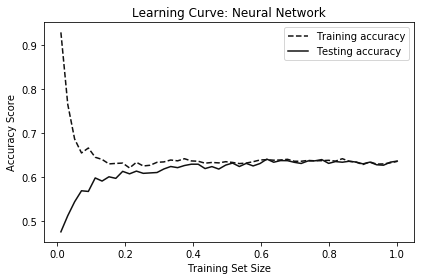

In [72]:
tr_size = np.linspace(0.01, 1.0, 50)
size = []
tr_accuracy = []
test_accuracy = []
n_tr_samples = X_train.shape[0]
for t in tr_size:
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,50), random_state=1) 
    clf.fit(X_train[ :int(n_tr_samples*t)], y_train[ :int(n_tr_samples*t)])
    size.append(int(n_tr_samples*t))
    t = accuracy_score(y_train[ :int(n_tr_samples*t)],clf.predict(X_train[ :int(n_tr_samples*t)]) )
    tr_accuracy.append(t)
    test_accuracy.append(accuracy_score(y_test, clf.predict(X_test)))
    
# Draw lines
plt.plot(tr_size, tr_accuracy, '--', color="#111111",  label="Training accuracy")
plt.plot(tr_size, test_accuracy, color="#111111", label="Testing accuracy")

# Create plot
plt.title("Learning Curve: Neural Network")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

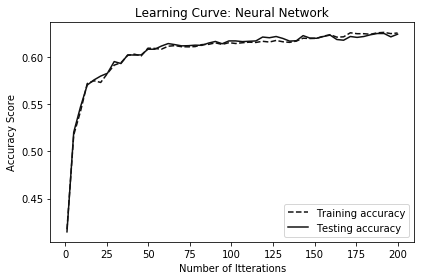

In [57]:
n_of_itterations = np.linspace(1, 200, 50)
tr_accuracy = []
test_accuracy = []
n_tr_samples = X_train.shape[0]
for t in n_of_itterations:
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,50), random_state=1, max_iter = t) 
    clf.fit(X_train, y_train)
    t = accuracy_score(y_train,clf.predict(X_train))
    tr_accuracy.append(t)
    test_accuracy.append(accuracy_score(y_test, clf.predict(X_test)))
    
# Draw lines
plt.plot(n_of_itterations, tr_accuracy, '--', color="#111111",  label="Training accuracy")
plt.plot(n_of_itterations, test_accuracy, color="#111111", label="Testing accuracy")

# Create plot
plt.title("Learning Curve: Neural Network")
plt.xlabel("Number of Itterations"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

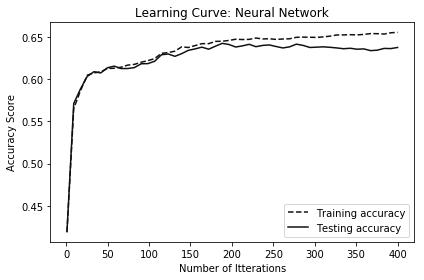

In [74]:
n_of_itterations = np.linspace(1, 400, 50)
tr_accuracy = []
test_accuracy = []
n_tr_samples = X_train.shape[0]
for t in n_of_itterations:
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,100), random_state=1, max_iter = t) 
    clf.fit(X_train, y_train)
    t = accuracy_score(y_train,clf.predict(X_train))
    tr_accuracy.append(t)
    test_accuracy.append(accuracy_score(y_test, clf.predict(X_test)))
    
# Draw lines
plt.plot(n_of_itterations, tr_accuracy, '--', color="#111111",  label="Training accuracy")
plt.plot(n_of_itterations, test_accuracy, color="#111111", label="Testing accuracy")

# Create plot
plt.title("Learning Curve: Neural Network")
plt.xlabel("Number of Itterations"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [75]:
# predict on the test data using the best parameters
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,100), random_state=1, max_iter =200) 
clf.fit(X_train, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
pr = clf.predict(X_test)
print("Testing accuracy: ", accuracy_score(y_test, pr))

Training accuracy:  0.6459804517607445
Testing accuracy:  0.6386083052749719


## Boosting

Boosting. Implement or steal a boosted version of your decision trees. As before, you will want to use some form of pruning, but presumably because you're using boosting you can afford to be much more aggressive about your pruning.

In [60]:
from sklearn.ensemble import AdaBoostClassifier

In [61]:
numb_of_estimators = [10, 50, 250]
max_depth_of_tree = [1, 10, 25, 40]

for i in numb_of_estimators:
    for j in max_depth_of_tree:
        clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=j),n_estimators=i, random_state=1) 
        scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        print(" number of estimators: ", i, "max depth of tree: ", j,  " accuracy: ", np.median(scores))

 number of estimators:  10 max depth of tree:  1  accuracy:  0.5885928003740065
 number of estimators:  10 max depth of tree:  10  accuracy:  0.5491937368544052
 number of estimators:  10 max depth of tree:  25  accuracy:  0.5912596401028277
 number of estimators:  10 max depth of tree:  40  accuracy:  0.5928955363402664
 number of estimators:  50 max depth of tree:  1  accuracy:  0.6142155716623802
 number of estimators:  50 max depth of tree:  10  accuracy:  0.535438596491228
 number of estimators:  50 max depth of tree:  25  accuracy:  0.5938303341902313
 number of estimators:  50 max depth of tree:  40  accuracy:  0.5892940626460963
 number of estimators:  250 max depth of tree:  1  accuracy:  0.6106566954896003
 number of estimators:  250 max depth of tree:  10  accuracy:  0.4689107059373539
 number of estimators:  250 max depth of tree:  25  accuracy:  0.5427769985974754
 number of estimators:  250 max depth of tree:  40  accuracy:  0.5550362234166861


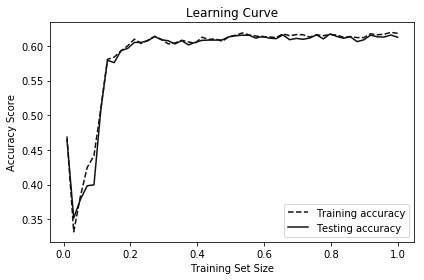

In [62]:
tr_size = np.linspace(0.01, 1.0, 50)
size = []
tr_accuracy = []
test_accuracy = []
n_tr_samples = X_train.shape[0]
for t in tr_size:
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),n_estimators=50, random_state=1)
    clf.fit(X_train[ :int(n_tr_samples*t)], y_train[ :int(n_tr_samples*t)])
    size.append(int(n_tr_samples*t))
    t = accuracy_score(y_train[ :int(n_tr_samples*t)],clf.predict(X_train[ :int(n_tr_samples*t)]) )
    tr_accuracy.append(t)
    test_accuracy.append(accuracy_score(y_test, clf.predict(X_test)))
    
# Draw lines
plt.plot(tr_size, tr_accuracy, '--', color="#111111",  label="Training accuracy")
plt.plot(tr_size, test_accuracy, color="#111111", label="Testing accuracy")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()    

In [63]:
# predict on the test data using the best parameters
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),n_estimators=50, random_state=1)
clf.fit(X_train, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
pr = clf.predict(X_test)
print("Testing accuracy: ", accuracy_score(y_test, pr))

Training accuracy:  0.6182949071692466
Testing accuracy:  0.6126075570520015


## Support Vector Machine

Support Vector Machines. You should implement (for sufficiently loose definitions of implement including "download") SVMs. This should be done in such a way that you can swap out kernel functions. I'd like to see at least two.

In [31]:
from sklearn.svm import SVC

In [65]:
clf = SVC(kernel="linear",random_state=1)
clf.fit(X_train, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
pr = clf.predict(X_test)
print("Testing accuracy: ", accuracy_score(y_test, pr))

Training accuracy:  0.5685825188233643
Testing accuracy:  0.5720164609053497


In [66]:
clf = SVC(kernel="poly", degree=2, random_state=1)
clf.fit(X_train, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
pr = clf.predict(X_test)
print("Testing accuracy: ", accuracy_score(y_test, pr))

Training accuracy:  0.5866810082776037
Testing accuracy:  0.5914702581369248


In [67]:
clf = SVC(kernel="poly", degree=3, random_state=1)
clf.fit(X_train, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
pr = clf.predict(X_test)
print("Testing accuracy: ", accuracy_score(y_test, pr))

Training accuracy:  0.5691437122948136
Testing accuracy:  0.5751964085297419


In [68]:
clf = SVC(kernel="rbf", random_state=1)
clf.fit(X_train, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
pr = clf.predict(X_test)
print("Testing accuracy: ", accuracy_score(y_test, pr))

Training accuracy:  0.6046859654866015
Testing accuracy:  0.6107369996258886


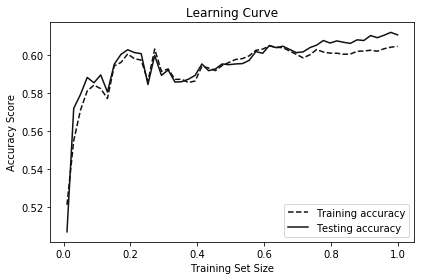

In [69]:
tr_size = np.linspace(0.01, 1.0, 50)
size = []
tr_accuracy = []
test_accuracy = []
n_tr_samples = X_train.shape[0]
for t in tr_size:
    clf =  SVC(kernel="rbf", random_state=1)
    clf.fit(X_train[ :int(n_tr_samples*t)], y_train[ :int(n_tr_samples*t)])
    size.append(int(n_tr_samples*t))
    t = accuracy_score(y_train[ :int(n_tr_samples*t)],clf.predict(X_train[ :int(n_tr_samples*t)]) )
    tr_accuracy.append(t)
    test_accuracy.append(accuracy_score(y_test, clf.predict(X_test)))
    
# Draw lines
plt.plot(tr_size, tr_accuracy, '--', color="#111111",  label="Training accuracy")
plt.plot(tr_size, test_accuracy, color="#111111", label="Testing accuracy")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

## KNN

k-Nearest Neighbors. You should "implement" (the quotes mean I don't mean it: steal the code) kNN. Use different values of k.

In [70]:
from sklearn.neighbors import KNeighborsClassifier

In [71]:
k = [3, 5, 11, 21, 30, 50, 70, 100]

numb_of_estimators = [10, 50, 250]
max_depth_of_tree = [1, 10, 25, 50, 100, 250]

for i in k:
    clf = KNeighborsClassifier(n_neighbors=i) 
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    print(" number of estimators: ", i, "max depth of tree: ", j,  " accuracy: ", np.median(scores))

 number of estimators:  3 max depth of tree:  40  accuracy:  0.573632538569425
 number of estimators:  5 max depth of tree:  40  accuracy:  0.5844823556905819
 number of estimators:  11 max depth of tree:  40  accuracy:  0.5986442262739597
 number of estimators:  21 max depth of tree:  40  accuracy:  0.6091631603553063
 number of estimators:  30 max depth of tree:  40  accuracy:  0.6087870997896705
 number of estimators:  50 max depth of tree:  40  accuracy:  0.6008413180649684
 number of estimators:  70 max depth of tree:  40  accuracy:  0.6035530621785882
 number of estimators:  100 max depth of tree:  40  accuracy:  0.5978489595510872


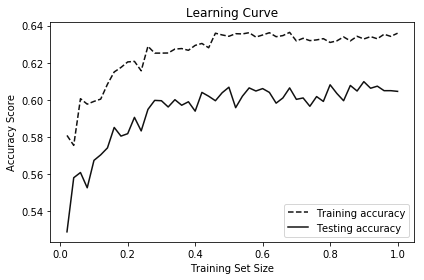

In [72]:
tr_size = np.linspace(0.02, 1.0, 50)
size = []
tr_accuracy = []
test_accuracy = []
n_tr_samples = X_train.shape[0]
for t in tr_size:
    clf = KNeighborsClassifier(n_neighbors=21)
    clf.fit(X_train[ :int(n_tr_samples*t)], y_train[ :int(n_tr_samples*t)])
    size.append(int(n_tr_samples*t))
    t = accuracy_score(y_train[ :int(n_tr_samples*t)],clf.predict(X_train[ :int(n_tr_samples*t)]) )
    tr_accuracy.append(t)
    test_accuracy.append(accuracy_score(y_test, clf.predict(X_test)))
    
# Draw lines
plt.plot(tr_size, tr_accuracy, '--', color="#111111",  label="Training accuracy")
plt.plot(tr_size, test_accuracy, color="#111111", label="Testing accuracy")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

In [73]:
clf = KNeighborsClassifier(n_neighbors=21)
clf.fit(X_train, y_train)
print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
pr = clf.predict(X_test)
print("Testing accuracy: ", accuracy_score(y_test, pr))

Training accuracy:  0.6359257353972783
Testing accuracy:  0.6045641601197157
